<a href="https://colab.research.google.com/github/ad709kr/NYC-Taxi-Trip-Time-Predction/blob/main/NYC_trip_time_prediction_individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Name    -  NYC Taxi Trip Time Prediction 

## Project Summary 
Task  is to build model to predicts the total ride duration of taxi trip in the New York city.Your primary dataset is one released by NYC Taxi and Limousine commission, which includes pickup time, geo-coordinates, number of passengers, and total other variables.

## Problem statement
Given the dataset, we have to predict the taxi trip duration.

## Dataset description  
**id** - a unique identifier for each trip
<br>**vendor_id** - a code indicating the provider associated with the trip record
<br>**pickup_datetime** - date and time when the meter was engaged
<br>**dropoff_datetime** - date and time when the meter was disengaged
<br>**passenger_count** - the number of passengers in the vehicle (driver entered value)
<br>**pickup_longitude** - the longitude where the meter was engaged
<br>**pickup_latitude** - the latitude where the meter was engaged
<br>**dropoff_longitude** - the longitude where the meter was disengaged
<br>**dropoff_latitude** - the latitude where the meter was disengaged
<br>**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward 
<br>**trip_duration** - duration of the trip in seconds




## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import great_circle
from math import radians, sin, cos, atan2,sqrt
from scipy import stats

from sklearn.preprocessing import StandardScaler
import folium # to plot street map

## Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = '/content/drive/MyDrive/Almabetter/regression_project/Copy of NYC Taxi Data.csv'
df = pd.read_csv(file)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
print("The shape of dataset is ",df.shape)

The shape of dataset is  (1458644, 11)


In [ ]:
# Checking null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
# checking duplicate
df[df.duplicated()].count()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**observation**
<br> There is no null, duplicate items in the dataset. Two features which needs to be converted in to the date_time function and to extract some features from that.

In [ ]:
# Lets convert pickup_datetime and drop_off datetime to datetime functions
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
#df = pd.to_datetime(df["dropoff_datetime"])

**Feature extraction**


In [ ]:
# date_time to day
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

In [ ]:
# date_time to month
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour

df['pickup_minute']=df['pickup_datetime'].dt.minute
df['dropoff_minute']=df['dropoff_datetime'].dt.minute

In [ ]:
def great_circle_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):
  pickup = (pickup_latitude,pickup_longitude)
  dropoff = (dropoff_latitude,dropoff_longitude)
  return great_circle(pickup,dropoff).km

'''def second_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):
  r = 6371.0
  pickup_lat = radians(pickup_latitude)
  pickup_lon = radians(pickup_longitude)
  
  dropoff_lat = radians(dropoff_latitude)
  dropoff_lon = radians(dropoff_longitude)

  dis_lat = dropoff_lat-pickup_lat
  dis_long = dropoff_lon-pickup_lon

  a = sin(dis_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dis_long / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a)) 


  return r*c'''

'def second_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):\n  r = 6371.0\n  pickup_lat = radians(pickup_latitude)\n  pickup_lon = radians(pickup_longitude)\n  \n  dropoff_lat = radians(dropoff_latitude)\n  dropoff_lon = radians(dropoff_longitude)\n\n  dis_lat = dropoff_lat-pickup_lat\n  dis_long = dropoff_lon-pickup_lon\n\n  a = sin(dis_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dis_long / 2)**2\n  c = 2 * atan2(sqrt(a), sqrt(1 - a)) \n\n\n  return r*c'

In [ ]:
df['trip_distance'] = df.apply(lambda x : great_circle_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,3,17,17,24,32,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,43,54,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,35,10,6.385108
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,4,19,19,32,39,1.485501
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,3,13,13,30,38,1.188590


In [ ]:
df.dtypes.value_counts()

int64             9
float64           5
object            4
datetime64[ns]    2
dtype: int64

In [ ]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,trip_distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,1.360648e+01,1.359890e+01,2.959016e+01,2.962843e+01,3.440869e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,6.399693e+00,6.483682e+00,1.732471e+01,1.742023e+01,4.296544e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,9.000000e+00,9.000000e+00,1.500000e+01,1.500000e+01,1.231838e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,1.400000e+01,1.400000e+01,3.000000e+01,3.000000e+01,2.093720e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01,4.500000e+01,4.500000e+01,3.875343e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,2.300000e+01,2.300000e+01,5.900000e+01,5.900000e+01,1.240910e+03


there are some trip having trip distance and trip duration equal to zero and some have very large value.

In [ ]:
# Lets count total trips having trip_duration or trip_distance equals to zero
'''
trip_zero_dur = 0
trip_zero_dis = 0
for val in df['trip_distance']:
  if val == 0:
    trip_zero_dis += 1
for val in df['trip_duration']:
  if val == 0:
    trip_zero_dur += 1
print(trip_zero_dur)
print(trip_zero_dis)'''

0
5897


<br> No trip can be possible if trip distance equal to zero, but from the data it is showing that total 5897 records have zero distance it could be either because :

*   Driver forgets to keep track of the distance
*   driver deliberately not entered to complete its daily target.
<br> So, In these case either we can impute these values or remove the records.
<br> since mean, median both values are different and 5897 records is very less compare to the total records so we removed it.



**outlier removal:** 
<br>we will follow two approach to remove outlier. The final dataset will be that having less data loss from the above two approaches.

**Outlier removal using inter quantile range**

In [ ]:
#outlier removal
"""
def upper_lower_range(df,col):
  quantile_1 = df[col].quantile(0.25)
  quantile_3 = df[col].quantile(0.75)
  iqr = quantile_3-quantile_1
  lower1 =  quantile_1 - 1.5 * iqr
  if lower1 < 0 :
    lower = 0
  else:
    lower = lower1
  upper = quantile_3 + 1.5 * iqr
  return lower,upper


lower_lim, upper_lim = upper_lower_range(df,'trip_distance')
lower_lim_dur,upper_lim_dur = upper_lower_range(df,'trip_duration')
"""


In [ ]:
#print(lower_lim) 
#print(upper_lim)

0
7.8405997722850165


In [ ]:
# outlier removal using trip_distance
#new_df = df[(df['trip_distance'] > lower_lim) & (df['trip_distance'] <= upper_lim)]
#new_df = new_df[(new_df['trip_duration'] > lower_lim_dur) & new_df['trip_duration'] < upper_lim_dur] 

In [ ]:
#data_loss = df.shape[0]-new_df.shape[0]
#print(" the data loss using iqr outlier removal technique is", data_loss*100/df.shape[0],"%")

 the data loss using iqr outlier removal technique is 10.048373695020855 %


**outlier removal using mean and variance**

In [ ]:
"""def outlier_removal_tech(df,col):
  mean = df[col].mean()
  s = df[col].std()
  low_lim = mean - 2*s
  if low_lim <0 :
    lower_limit = 0
  else:
    lower_limit = low_lim
  upper_limit = mean + 2*s
  #print(lower_limit)
  #print(upper_limit)
  new_df = df[(df[col] > lower_limit) & (df[col] < upper_limit)]
  return new_df
new_data = outlier_removal_tech(df,'trip_distance')
new_data1 = outlier_removal_tech(new_data,'trip_duration')"""

In [ ]:
"""data_loss2 = df.shape[0] - new_data1.shape[0]
print("the data loss is",data_loss2*100/df.shape[0],"%")"""

the data loss is 4.905035087382528 %


data loss is lesser in second approach, so we use the data obtained by second approach to do further analysis.

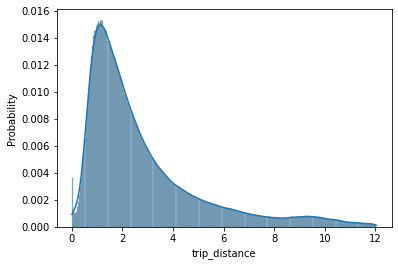

In [ ]:
#sns.histplot(data = new_data1, x = 'trip_distance',kde = True, stat = 'probability')

In [ ]:
#b = np.array(new_data1['trip_distance'])
#fitted_data, fitted_lambda = stats.boxcox(b)
#new_data1['trip_distance'] = list(fitted_data)
#sns.histplot(data = fitted_data, x =fitted_data,kde = True, stat = 'probability')

In [ ]:
#sns.distplot(new_data1['trip_distance'], kde = True)

we will not apply any transform on our target variable.

## Exploratory data analysis

In [ ]:
# list of the columns
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_day          1458644 non-null  object        
 12  dropoff_day         1458644 non-null  object        
 13  pickup_month

**Univariate analysis**

**1.Vendor_id :** Different vendors who provide taxi service.


In [ ]:
# Counting the unique value of each feature
df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Vendor_id')

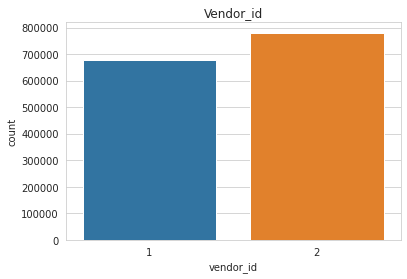

In [ ]:
# vendor_id
sns.set_style('whitegrid')
sns.countplot(df['vendor_id'])
plt.title("Vendor_id")

**observation :** there are two vendors. vendor having vendor_id 2 has maximum number of trip.

**2. passenger count**
-Total number of pessangers in taxi during trip.

In [ ]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [ ]:
print(df.shape)

(1458644, 20)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


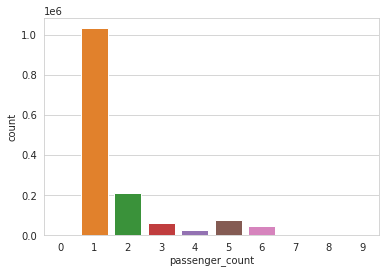

In [ ]:
# passenger_count
sns.countplot(df['passenger_count'])

**Observation :** 
<br>(1) 60 trip contain zero passenger, 3 times 7 and 1 times 8 and 9 passengers.
<br>(2) AS per NYC taxi cab, the maximum number allowed are 5 adult and 1 child, so total 6 passeger, so rest are outliers.
<br>(3) There 60 trips with zero pessanger, so it might be mistaken so it can be treated as outliers.

In [ ]:
#new_data1 = new_data1[(new_data1['passenger_count'] <= 6) & (new_data1['passenger_count'] > 0) ]

**3. store_and_fwd_flag :** The taxi that are storing the data in local memory and then sending to the server (Y) and the taxi that are directly sending to the server(no).

In [ ]:
df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


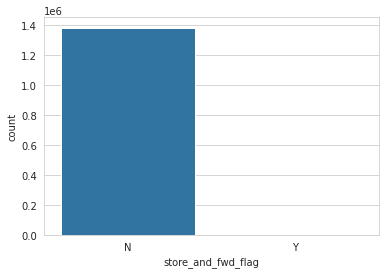

In [ ]:
#store_and_fwd_flag
sns.countplot(new_data1['store_and_fwd_flag'])

**4. Trip_duration**


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


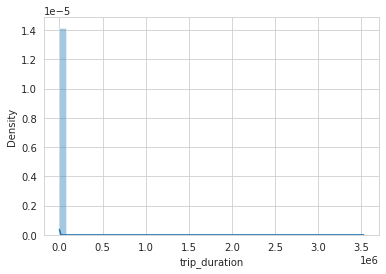

In [ ]:
sns.distplot(df['trip_duration'], kde = True)

In [ ]:
print(round(df['trip_duration'].describe(),3))

count    1458644.000
mean         959.492
std         5237.432
min            1.000
25%          397.000
50%          662.000
75%         1075.000
max      3526282.000
Name: trip_duration, dtype: float64


In [ ]:
# there are wide range in the data lets look it percentile wize
for i in range(0,101,10):
  print(f'the {i}th percentile value is ',df['trip_duration'].quantile(i/100))

the 0th percentile value is  1.0
the 10th percentile value is  245.0
the 20th percentile value is  348.0
the 30th percentile value is  446.0
the 40th percentile value is  548.0
the 50th percentile value is  662.0
the 60th percentile value is  798.0
the 70th percentile value is  968.0
the 80th percentile value is  1208.0
the 90th percentile value is  1634.0
the 100th percentile value is  3526282.0


In [ ]:
## it can oberseved that the range in 90th to 100th percentile is very high, so lets get deep into that
for i in range(90,101,1):
  print(f'the {i}th percentile value is ',df['trip_duration'].quantile(i/100))

the 90th percentile value is  1634.0
the 91th percentile value is  1703.0
the 92th percentile value is  1780.0
the 93th percentile value is  1869.0
the 94th percentile value is  1975.0
the 95th percentile value is  2104.0
the 96th percentile value is  2273.0
the 97th percentile value is  2497.0
the 98th percentile value is  2829.0
the 99th percentile value is  3440.0
the 100th percentile value is  3526282.0


In [ ]:
## In a day maximum 24 hours i.e, 86400 seconds occurs, so lets see the trips having trip_duration more than a day

df[df['trip_duration'] > 86400].shape

## so total 4 trips which took more than a day. 

(4, 20)

**observation** 
<br> (1) According to  NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours so any value greater than 43200 sec is an outlier.
<br>(2) Since mean > median, the curve is right skewed.
<br>(3) there are 4 trips having duration more than a day, it could be the weekend long drives or an outlier.
<br> (4) There is a huge gap in the 99th percentile value and the 100th percentile value.

**5. Trip distance**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


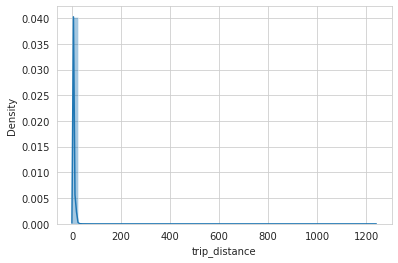

In [ ]:
sns.distplot(df['trip_distance'], kde = True)

In [ ]:
print(round(df['trip_distance'].describe(),3))

count    1458644.000
mean           3.441
std            4.297
min            0.000
25%            1.232
50%            2.094
75%            3.875
max         1240.910
Name: trip_distance, dtype: float64


In [ ]:
# there are wide range in the data lets look it percentile wize
for i in range(0,101,10):
  print(f'the {i}th percentile value is ',df['trip_distance'].quantile(i/100))

the 0th percentile value is  0.0
the 10th percentile value is  0.7924875182950804
the 20th percentile value is  1.0896034468137499
the 30th percentile value is  1.379891668569172
the 40th percentile value is  1.7063420940763
the 50th percentile value is  2.0937200906182802
the 60th percentile value is  2.5974760200003617
the 70th percentile value is  3.3369209095369565
the 80th percentile value is  4.619574528232555
the 90th percentile value is  7.630846411684088
the 100th percentile value is  1240.9104296218293


In [ ]:
# The 90th percentile value is 7.631 km, however the 100th percentile value is 1240.910 km so lets dive into the details
for i in range(90,101,1):
  print(f'the {i}th percentile value is ',df['trip_distance'].quantile(i/100))

the 90th percentile value is  7.630846411684088
the 91th percentile value is  8.255741160552953
the 92th percentile value is  8.888157434510978
the 93th percentile value is  9.45748400081812
the 94th percentile value is  10.081818207980135
the 95th percentile value is  11.01932079320989
the 96th percentile value is  12.815902679344854
the 97th percentile value is  15.416791495270484
the 98th percentile value is  19.369464575680794
the 99th percentile value is  20.78754851225841
the 100th percentile value is  1240.9104296218293


In [ ]:
for i in range(990,1001,1):
  print(f'the {i/10}th percentile value is ',df['trip_distance'].quantile(i/1000))

the 99.0th percentile value is  20.78754851225841
the 99.1th percentile value is  20.920180686704633
the 99.2th percentile value is  21.051516932566877
the 99.3th percentile value is  21.186669612107643
the 99.4th percentile value is  21.36594069505199
the 99.5th percentile value is  21.557401347058224
the 99.6th percentile value is  21.832228533259947
the 99.7th percentile value is  22.264987993745123
the 99.8th percentile value is  22.88986835445715
the 99.9th percentile value is  24.766793063720435
the 100.0th percentile value is  1240.9104296218293


**observation**<br> (1) There are some values with zero trip distance it might be corresponding to the one second time duration.
<br> (2) There are much difference between 99.9th percentile and 100th percentile value is significant, so we can treat the value above 99.9 percentile as outlier.
<br> (3) mean distance > median so the curve will be similat to the trip_duration curve.

**6.Pickup and dropoff day**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


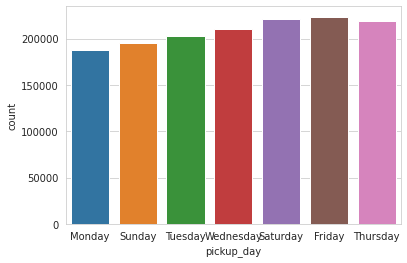

In [ ]:
# pickup day
sns.countplot(df['pickup_day'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


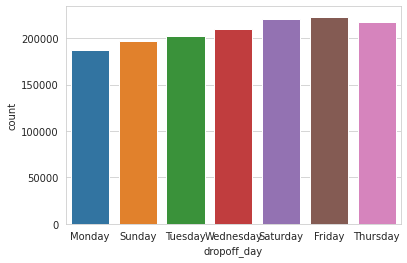

In [ ]:
sns.countplot(df['dropoff_day'])

<br> both  the graph are similar, friday and saturday have maximum number of trips.

**7. pickup and dropoff month**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


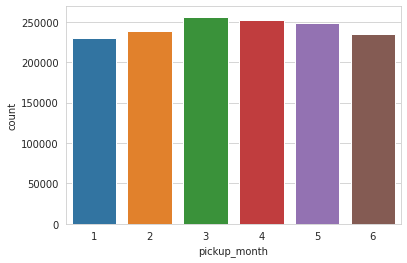

In [ ]:
sns.countplot(df['pickup_month'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


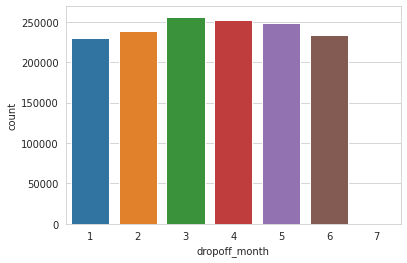

In [ ]:
sns.countplot(df['dropoff_month'])

<br> pickup and dropoff month both have similar graph.

**8.Longitude and latitude**

<br> New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004), however there are many coordinates which lie outside the bounded region for pickups and dropoffs

In [ ]:
#pip install folium 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Pickup Location**

In [85]:
outlier_locations = df[((df.pickup_longitude <= -74.15) | (df.pickup_latitude <= 40.5774)| \
                   (df.pickup_longitude >= -73.7004) | (df.pickup_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

**observation**
<br> (1) There are many pickups outside the newyork city as it can be seen, infact some pickup locations are in middle of the ocean.
<br> (2) All the points located in map can be treated as outliers.

**dropoff location**

In [ ]:
outlier_locations = df[((df.dropoff_longitude <= -74.15) | (df.dropoff_latitude <= 40.5774)| \
                   (df.dropoff_longitude >= -73.7004) | (df.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

**observation**
<br> (1) There are many pickups outside the newyork city as it can be seen, infact some pickup locations are in middle of the ocean.
<br> (2) All the points located in map can be treated as outliers.

**Bivariate analysis**

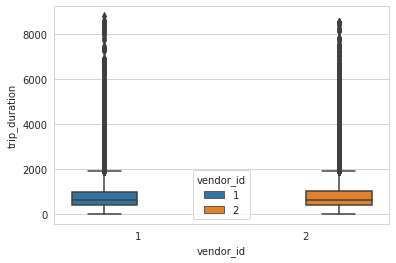

In [ ]:
# vendor_id vs trip duration
sns.boxplot(data = new_data1, x = 'vendor_id', y ='trip_duration', hue='vendor_id')


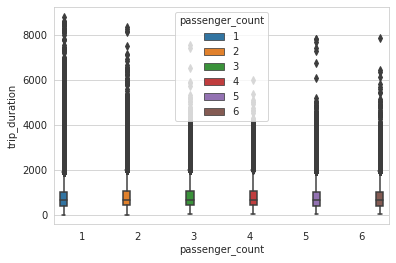

In [ ]:
sns.boxplot(data =new_data1, x = 'passenger_count', y ='trip_duration', hue='passenger_count')


<br> 60 trip have zero pessanger count, 1 trip have 7,8 and 9 passenger counts.


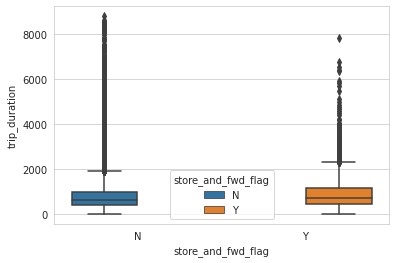

In [ ]:
sns.boxplot(data =new_data1, x = 'store_and_fwd_flag', y ='trip_duration', hue='store_and_fwd_flag')

Text(0.5, 1.0, 'trip_distance vs trip_duration')

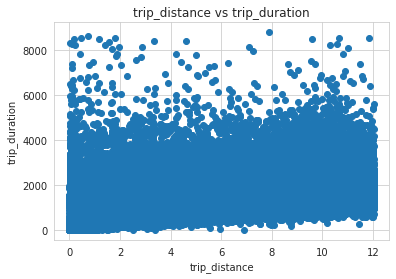

In [ ]:
plt.scatter(new_data1['trip_distance'],new_data1['trip_duration'])
plt.xlabel("trip_distance")
plt.ylabel("trip_duration")
plt.title("trip_distance vs trip_duration")

In [ ]:
#plt.scatter(new_data1['pickup_latitude'],new_data1['pickup_longitude'],'r')
#plt.scatter(new_data1['dropoff_latitude'],new_data1['dropoff_longitude','g'])
#plt.xlabel("Latitude")
#plt.ylabel("Longitude")
#plt.show()

**Multivariate analysis**

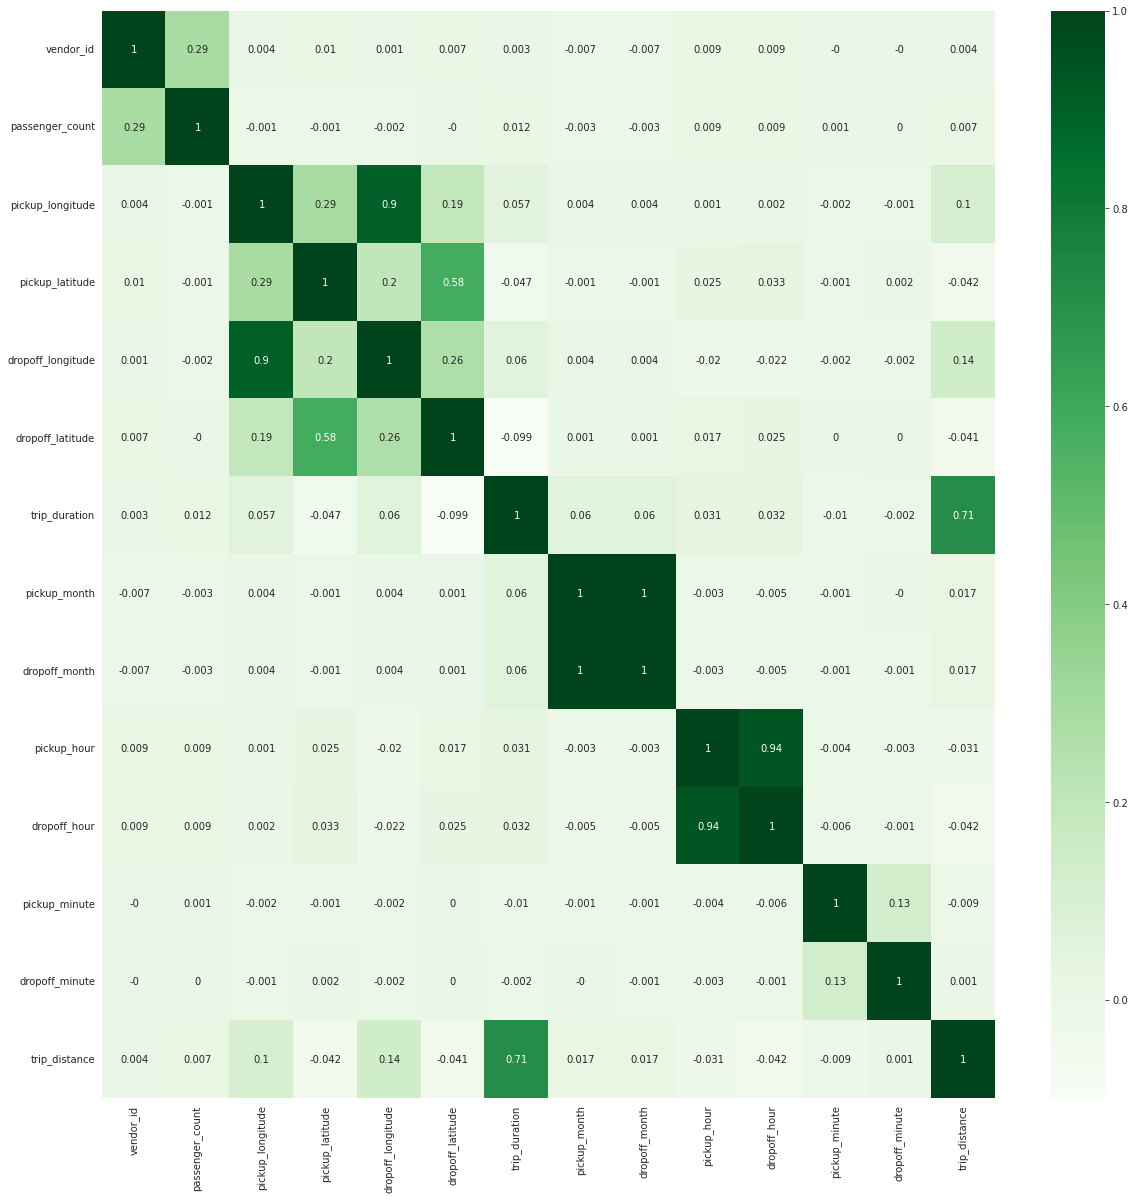

In [ ]:
corr = round(new_data1.corr(),3)
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap="Greens",annot=True)


## Train test split

In [ ]:
new_data1.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance'],
      dtype='object')

In [ ]:
# since our target variable is trip_duration 
Y = new_data1['trip_duration']
# Keeping pickup datetime to perform time based splitting
X = new_data1[['vendor_id','pickup_datetime','passenger_count','store_and_fwd_flag','pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance']]